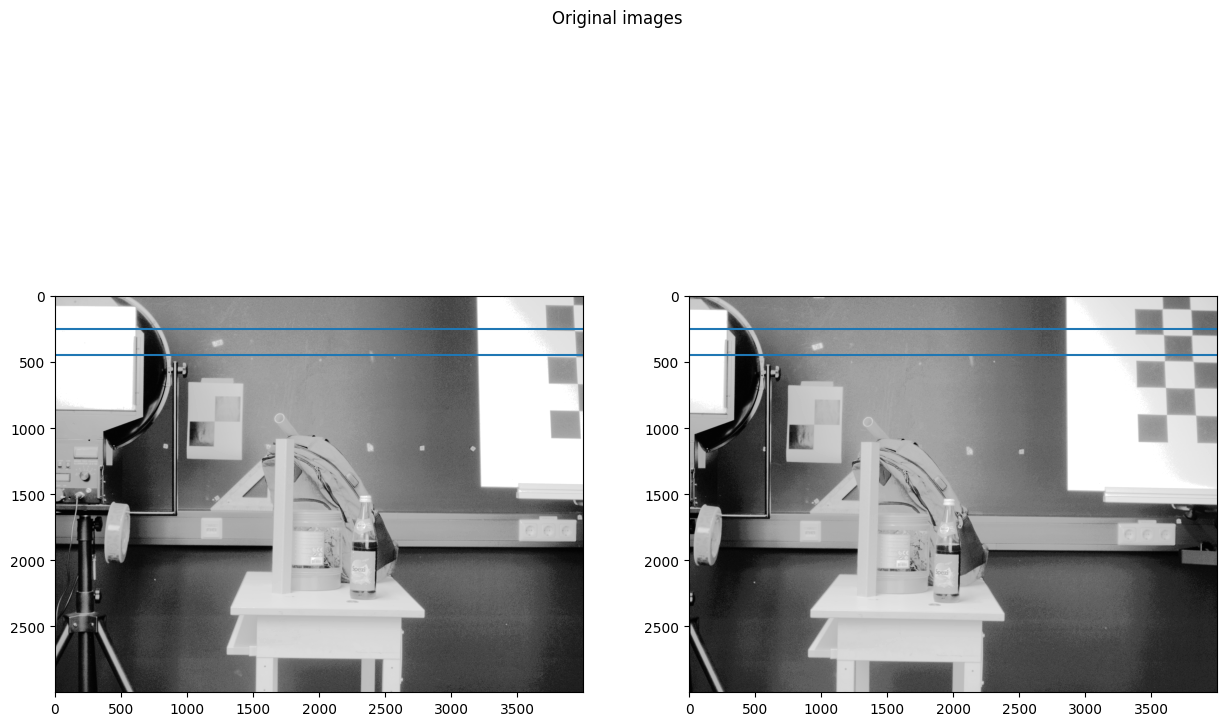

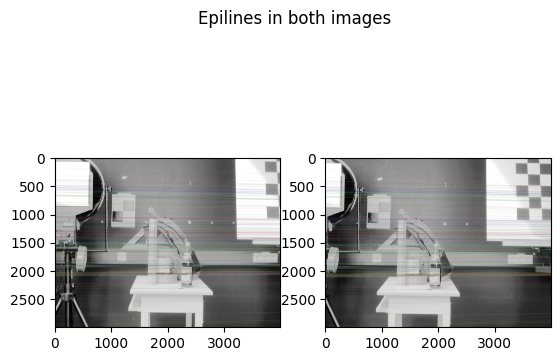

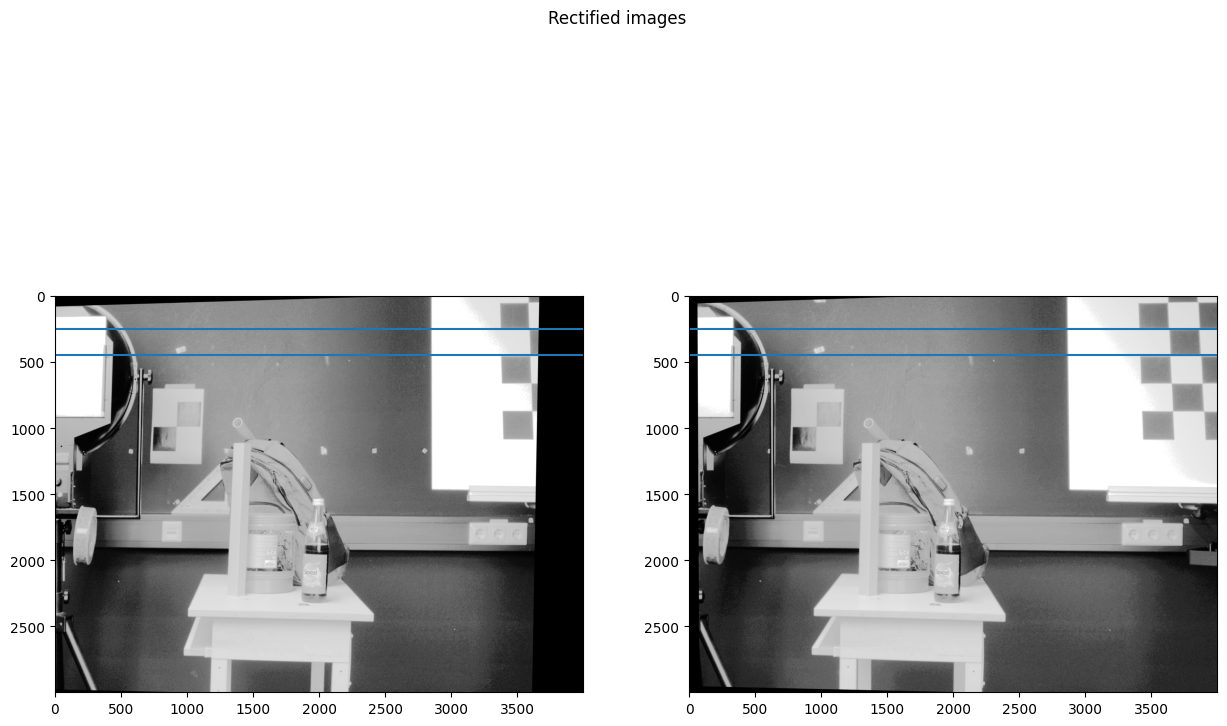

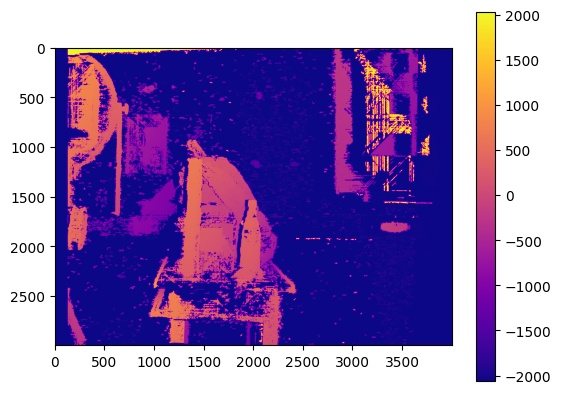

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Function to resize images to Full HD
def resize_to_full_hd(image):
    return cv.resize(image, (1920, 1080), interpolation=cv.INTER_LINEAR)

# Read both images and convert to grayscale
img1 = cv.imread('../../02_Utils/Images/LINKS_V3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('../../02_Utils/Images/Rechts_V3.png', cv.IMREAD_GRAYSCALE)

# Test 1 
img1 = cv.equalizeHist(img1)
img2 = cv.equalizeHist(img2)
# ------------------------------------------------------------
# PREPROCESSING

# Compare unprocessed images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.savefig("original_images.png")
plt.show()

# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Visualize keypoints
imgSift = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgSift = resize_to_full_hd(imgSift)
cv.imshow("SIFT Keypoints", imgSift)
cv.imwrite("sift_keypoints.png", imgSift)

# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
keypoint_matches = resize_to_full_hd(keypoint_matches)
cv.imshow("Keypoint matches", keypoint_matches)
cv.imwrite("keypoint_matches.png", keypoint_matches)


# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html


def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

def save_disparity_map(disparity, save_path):
    """
    Speichert die Tiefenkarte (Disparity Map) an einem angegebenen Pfad.

    Parameters:
    disparity (numpy.ndarray): Die zu speichernde Tiefenkarte.
    save_path (str): Der Pfad, an dem die Tiefenkarte gespeichert wird.
    """
    # Normalize the values to a range from 0..255 for a grayscale image
    disparity_normalized = cv.normalize(disparity, None, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)

    # Save the disparity map
    cv.imwrite(save_path, disparity_normalized)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.savefig("epilines.png")
plt.show()


# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Rectify (undistort) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

# ------------------------------------------------------------
# CALCULATE DISPARITY (DEPTH MAP)
# Adapted from: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
# and: https://docs.opencv.org/master/dd/d53/tutorial_py_depthmap.html

# StereoSGBM Parameter explanations:
# https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 11
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
disparity_SGBM = resize_to_full_hd(disparity_SGBM)
cv.imshow("Disparity", disparity_SGBM)
#cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)

    
    
save_path = '../../02_Utils/Images/Disparity_SGBM_2.png'
save_disparity_map(disparity_SGBM, save_path)

cv.waitKey()
cv.destroyAllWindows()
# ---------------------------------------------------------------

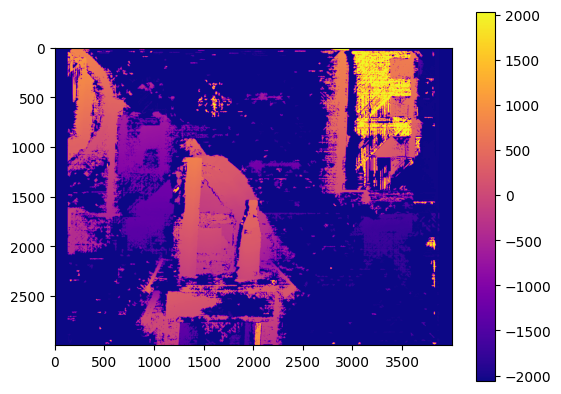

In [13]:
# Testbox

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Function to resize images to Full HD
def resize_to_full_hd(image):
    return cv.resize(image, (1920, 1080), interpolation=cv.INTER_LINEAR)

# Read both images and convert to grayscale
img1 = cv.imread('../../02_Utils/Images/LINKS_V3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('../../02_Utils/Images/Rechts_V3.png', cv.IMREAD_GRAYSCALE)

# Define the bounding box of the chessboard (example coordinates)
chessboard_bbox = ((1000, 300), (1500, 700))

# Apply a Gaussian Blur to reduce the contrast in the area of the chessboard
def blur_chessboard_area(image, bbox):
    x_min, y_min, x_max, y_max = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
    image[y_min:y_max, x_min:x_max] = cv.GaussianBlur(image[y_min:y_max, x_min:x_max], (31, 31), 0)
    return image

img1 = blur_chessboard_area(img1, chessboard_bbox)
img2 = blur_chessboard_area(img2, chessboard_bbox)

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Function to filter keypoints within a bounding box
def filter_keypoints(kp, bbox):
    filtered_kp = []
    for point in kp:
        x, y = point.pt
        if not (bbox[0][0] <= x <= bbox[1][0] and bbox[0][1] <= y <= bbox[1][1]):
            filtered_kp.append(point)
    return filtered_kp

# Apply the filter to your keypoints
kp1_filtered = filter_keypoints(kp1, chessboard_bbox)
kp2_filtered = filter_keypoints(kp2, chessboard_bbox)

# Recompute descriptors for the filtered keypoints
kp1_filtered, des1_filtered = sift.compute(img1, kp1_filtered)
kp2_filtered, des2_filtered = sift.compute(img2, kp2_filtered)

# Proceed with the rest of your code using filtered keypoints and descriptors
# Match keypoints in both images
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1_filtered, des2_filtered, k=2)

# Keep good matches
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2_filtered[m.trainIdx].pt)
        pts1.append(kp1_filtered[m.queryIdx].pt)

# The rest of your existing code follows...

# Calculate the fundamental matrix for the cameras
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Visualize epilines (existing code)...

# Stereo rectification
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Rectify (undistort) the images and save them
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))

# Calculate disparity (existing code)...

# StereoSGBM parameters
block_size = 7
min_disp = -128
max_disp = 128
num_disp = max_disp - min_disp
uniquenessRatio = 5
speckleWindowSize = 200
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
disparity_SGBM = resize_to_full_hd(disparity_SGBM)
cv.imshow("Disparity", disparity_SGBM)

save_path = '../../02_Utils/Images/Disparity_SGBM_3.png'
save_disparity_map(disparity_SGBM, save_path)

cv.waitKey(0)
cv.destroyAllWindows()

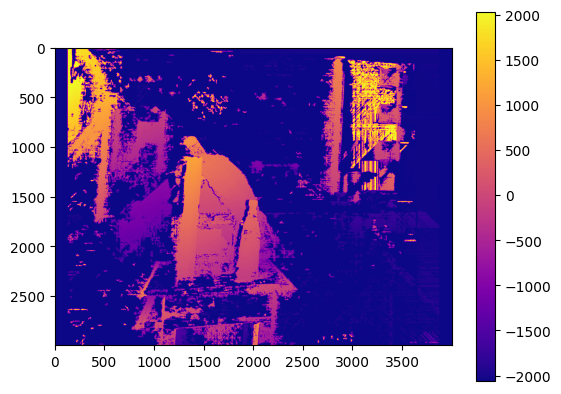

In [9]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Function to resize images to Full HD
def resize_to_full_hd(image):
    return cv.resize(image, (1920, 1080), interpolation=cv.INTER_LINEAR)

# Function to save the disparity map
def save_disparity_map(disparity, save_path):
    disparity_normalized = cv.normalize(disparity, None, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)
    cv.imwrite(save_path, disparity_normalized)

# Function to blur chessboard area
def blur_chessboard_area(image, bbox):
    x_min, y_min, x_max, y_max = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
    image[y_min:y_max, x_min:x_max] = cv.GaussianBlur(image[y_min:y_max, x_min:x_max], (31, 31), 0)
    return image

# Define bounding box of the chessboard (example coordinates)
chessboard_bbox = ((1000, 300), (1500, 700))

# Read both images and convert to grayscale
img1 = cv.imread('../../02_Utils/Images/LINKS_V3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('../../02_Utils/Images/Rechts_V3.png', cv.IMREAD_GRAYSCALE)

# Blur chessboard areas
img1 = blur_chessboard_area(img1, chessboard_bbox)
img2 = blur_chessboard_area(img2, chessboard_bbox)

# Initiate SIFT detector
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Filter keypoints within the bounding box
def filter_keypoints(kp, bbox):
    filtered_kp = []
    for point in kp:
        x, y = point.pt
        if not (bbox[0][0] <= x <= bbox[1][0] and bbox[0][1] <= y <= bbox[1][1]):
            filtered_kp.append(point)
    return filtered_kp

kp1_filtered = filter_keypoints(kp1, chessboard_bbox)
kp2_filtered = filter_keypoints(kp2, chessboard_bbox)

# Recompute descriptors for the filtered keypoints
kp1_filtered, des1_filtered = sift.compute(img1, kp1_filtered)
kp2_filtered, des2_filtered = sift.compute(img2, kp2_filtered)

# Match keypoints in both images
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1_filtered, des2_filtered, k=2)

# Keep good matches
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2_filtered[m.trainIdx].pt)
        pts1.append(kp1_filtered[m.queryIdx].pt)

# Calculate the fundamental matrix for the cameras
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# Select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Stereo rectification
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Rectify (undistort) the images and save them
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w1, h1))

# Calculate disparity using StereoSGBM
block_size = 7
min_disp = -128
max_disp = 128
num_disp = max_disp - min_disp
uniquenessRatio = 5
speckleWindowSize = 200
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

# Visualize disparity map
plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
disparity_SGBM = resize_to_full_hd(disparity_SGBM)
cv.imshow("Disparity", disparity_SGBM)

# Save disparity map
save_path = '../../02_Utils/Images/Disparity_SGBM_4.png'
save_disparity_map(disparity_SGBM, save_path)

cv.waitKey(0)
cv.destroyAllWindows()

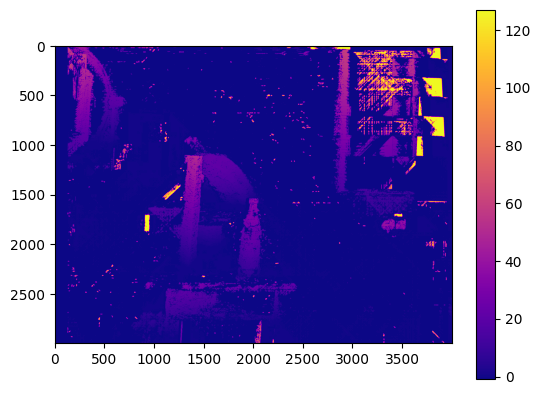

In [12]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Function to resize images to Full HD
def resize_to_full_hd(image):
    return cv.resize(image, (1920, 1080), interpolation=cv.INTER_LINEAR)

# Function to save the disparity map
def save_disparity_map(disparity, save_path):
    disparity_normalized = cv.normalize(disparity, None, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)
    cv.imwrite(save_path, disparity_normalized)

# Function to blur chessboard area
def blur_chessboard_area(image, bbox):
    x_min, y_min, x_max, y_max = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
    image[y_min:y_max, x_min:x_max] = cv.GaussianBlur(image[y_min:y_max, x_min:x_max], (31, 31), 0)
    return image

# Define bounding box of the chessboard (example coordinates)
chessboard_bbox = ((1000, 300), (1500, 700))

# Read both images and convert to grayscale
img1 = cv.imread('../../02_Utils/Images/LINKS_V3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('../../02_Utils/Images/Rechts_V3.png', cv.IMREAD_GRAYSCALE)

# Blur chessboard areas and apply median filter
img1 = blur_chessboard_area(img1, chessboard_bbox)
img1 = cv.medianBlur(img1, 5)
img2 = blur_chessboard_area(img2, chessboard_bbox)
img2 = cv.medianBlur(img2, 5)

# Initiate SIFT detector
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Filter keypoints within the bounding box
def filter_keypoints(kp, bbox):
    filtered_kp = []
    for point in kp:
        x, y = point.pt
        if not (bbox[0][0] <= x <= bbox[1][0] and bbox[0][1] <= y <= bbox[1][1]):
            filtered_kp.append(point)
    return filtered_kp

kp1_filtered = filter_keypoints(kp1, chessboard_bbox)
kp2_filtered = filter_keypoints(kp2, chessboard_bbox)

# Recompute descriptors for the filtered keypoints
kp1_filtered, des1_filtered = sift.compute(img1, kp1_filtered)
kp2_filtered, des2_filtered = sift.compute(img2, kp2_filtered)

# Match keypoints in both images
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1_filtered, des2_filtered, k=2)

# Keep good matches
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2_filtered[m.trainIdx].pt)
        pts1.append(kp1_filtered[m.queryIdx].pt)

# Calculate the fundamental matrix for the cameras
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# Select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Stereo rectification
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Rectify (undistort) the images and save them
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w1, h1))

# Calculate disparity using StereoSGBM
block_size = 5  # It can be tuned from 3 to 11
min_disp = 0
num_disp = 128  # It should be divisible by 16
uniquenessRatio = 15
speckleWindowSize = 50
speckleRange = 1
disp12MaxDiff = 1

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

disparity_SGBM = stereo.compute(img1_rectified, img2_rectified).astype(np.float32)

# Convert disparity map to CV_16SC1 format for speckle filtering
disparity_SGBM = np.int16(disparity_SGBM)

# Apply speckle filter
cv.filterSpeckles(disparity_SGBM, newVal=0, maxSpeckleSize=speckleWindowSize, maxDiff=speckleRange)

# Convert the filtered disparity map back to float32 for visualization
disparity_SGBM = disparity_SGBM.astype(np.float32) / 16.0

# Visualize disparity map
plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
disparity_SGBM = resize_to_full_hd(disparity_SGBM)
cv.imshow("Disparity", disparity_SGBM)

# Save disparity map
save_path = '../../02_Utils/Images/Disparity_SGBM_5.png'
save_disparity_map(disparity_SGBM, save_path)

cv.waitKey(0)
cv.destroyAllWindows()

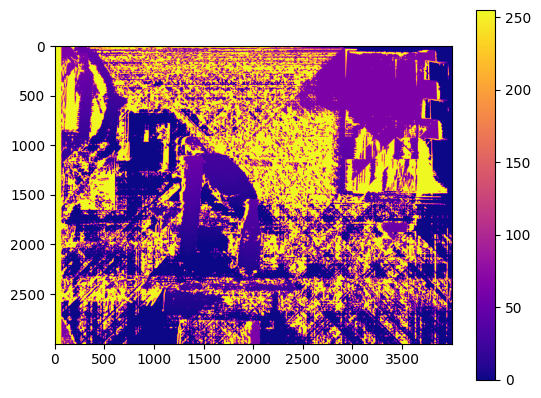

In [14]:
# GPT Vorschlag
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Function to resize images to Full HD
def resize_to_full_hd(image):
    return cv.resize(image, (1920, 1080), interpolation=cv.INTER_LINEAR)

# Function to save the disparity map
def save_disparity_map(disparity, save_path):
    disparity_normalized = cv.normalize(disparity, None, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)
    cv.imwrite(save_path, disparity_normalized)

# Step 1: Load images and convert to grayscale
imgL = cv.imread('../../02_Utils/Images/LINKS_V3.png')
imgR = cv.imread('../../02_Utils/Images/Rechts_V3.png')

grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
grayR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

# Step 2: Apply Gaussian blur to reduce noise
grayL_blurred = cv.GaussianBlur(grayL, (5, 5), 0)
grayR_blurred = cv.GaussianBlur(grayR, (5, 5), 0)

# Step 3: Compute the keypoints and descriptors using SIFT
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(grayL_blurred, None)
kp2, des2 = sift.detectAndCompute(grayR_blurred, None)

# Step 4: Match keypoints using BFMatcher
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Step 5: Compute the fundamental matrix
F, mask = cv.findFundamentalMat(src_pts, dst_pts, cv.FM_RANSAC)

# Step 6: We select only inlier points
src_pts_inliers = src_pts[mask.ravel() == 1]
dst_pts_inliers = dst_pts[mask.ravel() == 1]

# Step 7: Stereo Rectification (uncalibrated variant)
h1, w1 = grayL.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(np.float32(src_pts_inliers), np.float32(dst_pts_inliers), F, imgSize=(w1, h1))

# Step 8: Rectify (undistort) the images
grayL_rectified = cv.warpPerspective(grayL, H1, (w1, h1))
grayR_rectified = cv.warpPerspective(grayR, H2, (w1, h1))

# Step 9: Compute the disparity map using StereoSGBM
min_disp = 0
num_disp = 64  # Must be divisible by 16
block_size = 9
stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = stereo.compute(grayL_rectified, grayR_rectified).astype(np.float32) / 16.0

# Post-processing: Apply filtering to improve disparity map
disp_filtered = cv.medianBlur(disparity, 5)

# Optional: Apply a bilateral filter to reduce noise while keeping edges sharp
disp_filtered = cv.bilateralFilter(np.uint8(disp_filtered), 9, 75, 75)

# Visualize the result
plt.imshow(disp_filtered, cmap='plasma')
plt.colorbar()
plt.show()

# Save the result
save_disparity_map(disp_filtered, '../../02_Utils/Images/Disparity_SGBM_filtered.png')

# Display the result
cv.imshow("Disparity", resize_to_full_hd(disp_filtered))
cv.waitKey(0)
cv.destroyAllWindows()

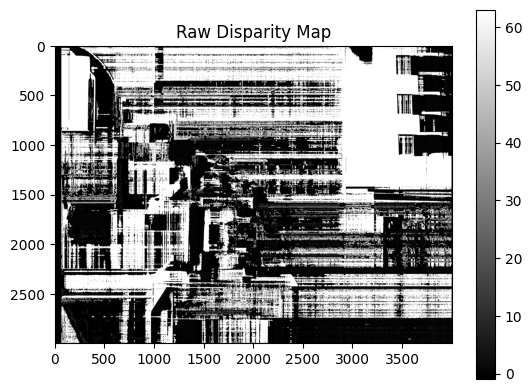

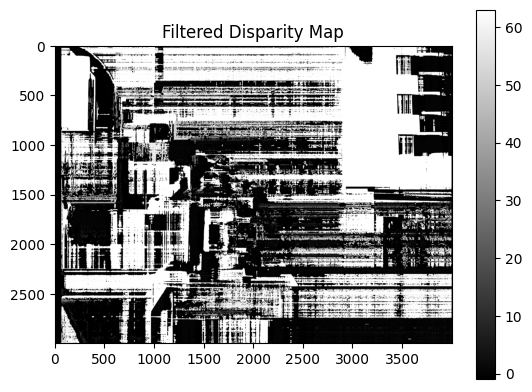

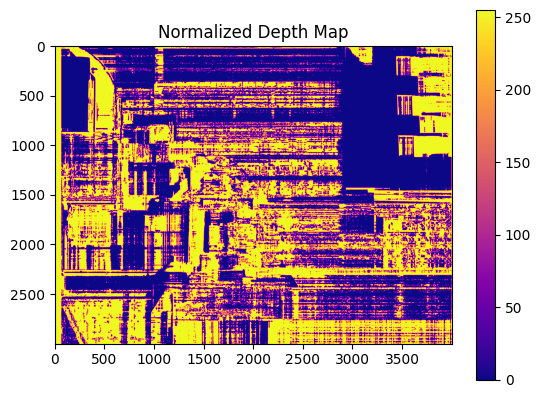

In [16]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Function to resize images to Full HD
def resize_to_full_hd(image):
    return cv.resize(image, (1920, 1080), interpolation=cv.INTER_LINEAR)

# Function to save the disparity map
def save_disparity_map(disparity, save_path):
    disparity_normalized = cv.normalize(disparity, None, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)
    cv.imwrite(save_path, disparity_normalized)

# Load images and convert to grayscale
imgL = cv.imread('../../02_Utils/Images/LINKS_V3.png')
imgR = cv.imread('../../02_Utils/Images/Rechts_V3.png')

grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
grayR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
grayL_blurred = cv.GaussianBlur(grayL, (5, 5), 0)
grayR_blurred = cv.GaussianBlur(grayR, (5, 5), 0)

# Intrinsic parameters
focal_length = 40.0  # in mm
baseline = 100.0  # distance between the cameras in mm (example value)
K1 = np.array([[focal_length, 0, grayL.shape[1] / 2],
               [0, focal_length, grayL.shape[0] / 2],
               [0, 0, 1]])
K2 = K1.copy()
D1 = np.zeros(5)  # Assuming no lens distortion
D2 = np.zeros(5)

# Extrinsic parameters
R = np.eye(3)
T = np.array([baseline, 0, 0])  # Assuming the cameras are aligned horizontally

# Stereo rectification
R1, R2, P1, P2, Q, _, _ = cv.stereoRectify(K1, D1, K2, D2, grayL.shape[::-1], R, T / 1000.0)  # Convert T to meters

# Rectify the images
map1_x, map1_y = cv.initUndistortRectifyMap(K1, D1, R1, P1, grayL.shape[::-1], cv.CV_32FC1)
map2_x, map2_y = cv.initUndistortRectifyMap(K2, D2, R2, P2, grayR.shape[::-1], cv.CV_32FC1)

grayL_rectified = cv.remap(grayL, map1_x, map1_y, cv.INTER_LINEAR)
grayR_rectified = cv.remap(grayR, map2_x, map2_y, cv.INTER_LINEAR)

# Compute disparity map
min_disp = 0
num_disp = 64  # Must be divisible by 16
block_size = 7

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
)

disparity = stereo.compute(grayL_rectified, grayR_rectified).astype(np.float32) / 16.0

# Debugging: Visualize the raw disparity map
plt.imshow(disparity, cmap='gray')
plt.colorbar()
plt.title("Raw Disparity Map")
plt.show()

# Post-processing: Apply median filter
disparity_filtered = cv.medianBlur(disparity, 5)

# Debugging: Visualize the filtered disparity map
plt.imshow(disparity_filtered, cmap='gray')
plt.colorbar()
plt.title("Filtered Disparity Map")
plt.show()

# Define near and far points (in meters)
near_point = 1.4  # 1400 mm
far_point = 3.6   # 3600 mm

# Convert disparity to depth (Z)
# Ensure that near_point and far_point are in the same units as the 3D reprojected points (meters in this case)
points_3D = cv.reprojectImageTo3D(disparity_filtered, Q)
depth_map = points_3D[:, :, 2]

# Mask values closer than near_point or farther than far_point
depth_map_mask = np.zeros_like(depth_map)
depth_map_mask[(depth_map > near_point) & (depth_map < far_point)] = 1
depth_map = np.ma.masked_array(depth_map, mask=1 - depth_map_mask)

# Normalize and clip depth map
depth_map = np.clip(depth_map, near_point, far_point)
depth_map_normalized = cv.normalize(depth_map, None, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
depth_map_normalized = np.uint8(depth_map_normalized)

# Debugging: Visualize the normalized depth map
plt.imshow(depth_map_normalized, cmap='plasma')
plt.colorbar()
plt.title("Normalized Depth Map")
plt.show()

# Save the result
save_disparity_map(depth_map_normalized, '../../02_Utils/Images/Depth_Map_filtered2.png')

# Display the result
cv.imshow("Depth Map", resize_to_full_hd(depth_map_normalized))
cv.waitKey(0)
cv.destroyAllWindows()